In [103]:
import json
import pickle
import importlib
import numpy as np
import pandas as pd
import scipy.stats as stats
from dragonmapper import hanzi
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, _tree
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, classification_report, matthews_corrcoef

import transform_data
importlib.reload(transform_data)
import calculate_frequencies
importlib.reload(calculate_frequencies)
import print_metrics
importlib.reload(print_metrics)

<module 'print_metrics' from 'd:\\Research\\tonal-adaptation\\print_metrics.py'>

In [104]:
# import data
data = {}

with open("./data/output_data.json", "r") as output_data_file:
    try:
        data = json.load(output_data_file)["words"]
    except Exception as e:
        print(e)

onset_frequencies = { }
onset_zh_frequencies = { }
tone_frequencies = { }

for word_en, word_data in data.items():
    onset = word_data["onset_en_ipa"]
    onset_frequencies[onset] = onset_frequencies[onset] + 1 if onset in onset_frequencies else 1

    onset_zh = word_data["word_zh"][0]
    onset_zh_frequencies[onset_zh] = onset_zh_frequencies[onset_zh] + 1 if onset_zh in onset_zh_frequencies else 1

    tone = word_data["onset_tone_num"]
    tone_frequencies[tone] = tone_frequencies[tone] + 1 if tone in tone_frequencies else 1

frequencies, cond_probs = calculate_frequencies.get_data()

onset_en_ipa_list = list(onset_frequencies.keys())
onset_zh_list = list(onset_zh_frequencies.keys())

In [105]:
# handle data
X = []
y = []
y_tones = []

X_labels = []
X_labels.append("Onset N(V)")
X_labels.append("Onset Length")
X_labels += ["close", "near-close", "close-mid", "mid", "open-mid", "near-open", "open"]
X_labels += ["front", "central", "back"]
X_labels.append("Onset N(C)")
X_labels.append("initial_stress_en")
X_labels.append("first_stress_en")
X_labels.append(f"F(Onset)")
X_labels += [f"P(Onset|T={tone})" for tone in range(1,5)]
X_labels += [f"P(T={tone}|Onset)" for tone in range(1,5)]
X_labels += [f"P(Onset|Hanzi={onset_zh})" for onset_zh in onset_zh_list]
X_labels += [f"P(Hanzi={onset_zh}|Onset)" for onset_zh in onset_zh_list]
# X_labels += ["N(Syllables)"]
X_labels += ["Onset%Word"]

# y_labels = ["Tone 1", "Tone 2", "Tone 3", "Tone 4"]
# y_labels = ["Tone 1/2", "Tone 3", "Tone 4"]
# y_labels = ["Tone 1/2", "Tone 3/4"]
# y_labels = ["Tone 1", "Tone 2/3/4"]
# y_labels = ["Tone 1/3", "Tone 2/4"]

y_labels = onset_zh_list

confident_onset_zh_list = [
    # "伊", "安", # 1
    # "艾", # 2
    # "埃", # 3
    # "阿", # 4
    # "亚", "以", "奥" # 5
    ###
    # "艾", # 1
    # "安", # 1
    # "伊", # 1
    # "亚", # 2
    # "埃", # 2
    # "奥", # 2
    # "阿", # 3
    # "以", # 4
    # "爱" # 5
    ###
    ["英", "乌", "厄", "安"], # 1
    # ["尤", "恩"], # 2
    # ["奥", "阿"], # 3
    # ["伊"], # 4
    # ["埃"], # 5
    # ["欧", "艾"], # 6
    # ["亚"] # 7
]
n = len(confident_onset_zh_list) + 1

for word_en, word_data in data.items():
    skip = False
    for m in range(n-1):
        if word_data["word_zh"][0] in confident_onset_zh_list[m]:
            skip = True
            break
    if skip:
        continue

    onset = word_data["onset_en_ipa"]

    x = transform_data.vowel_qualities(word_data["onset_en_ipa"])
    x.append(len(onset)-x[0])

    x.append(word_data["stresses_en"][0])

    x.append(word_data["stresses_en"].index(1))

    x.append(onset_frequencies[word_data["onset_en_ipa"]])

    for tone in [1,2,3,4]:
        x.append(cond_probs["onset_tone_num"][str(tone)].get(onset, False) or 0)

    for tone in [1,2,3,4]:
        x.append(cond_probs["onset_en_ipa"][onset].get(str(tone), False) or 0)

    for onset_zh in onset_zh_list:
        x.append(cond_probs["onset_zh"][onset_zh].get(str(onset), False) or 0)

    for onset_zh in onset_zh_list:
        x.append(cond_probs["onset_en_ipa-onset_zh"][onset].get(str(onset_zh), False) or 0)

    x.append(len(word_data["syllables_en_arpa"]) >= 2)

    # x.append(len(word_data["onset_en_ipa"])/len("".join(word_data["syllables_en_ipa"])))

    X.append(x)

    y.append(word_data["word_zh"][0])
    y_tones.append(word_data["onset_tone_num"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100, stratify=y_tones)

In [106]:
# create, train, and test model
clf = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=100, min_samples_split=2, min_samples_leaf=5)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# with open(f"./models_expanded/clf_onset_zh_step_{n}.pkl", "wb") as clf_onset_zh_file:
#     pickle.dump(clf, clf_onset_zh_file)

X_labels: ['Onset N(V)', 'Onset Length', 'close', 'near-close', 'close-mid', 'mid', 'open-mid', 'near-open', 'open', 'front', 'central', 'back', 'Onset N(C)', 'initial_stress_en', 'first_stress_en', 'F(Onset)', 'P(Onset|T=1)', 'P(Onset|T=2)', 'P(Onset|T=3)', 'P(Onset|T=4)', 'P(T=1|Onset)', 'P(T=2|Onset)', 'P(T=3|Onset)', 'P(T=4|Onset)', 'P(Onset|Hanzi=奥)', 'P(Onset|Hanzi=艾)', 'P(Onset|Hanzi=阿)', 'P(Onset|Hanzi=以)', 'P(Onset|Hanzi=伊)', 'P(Onset|Hanzi=亚)', 'P(Onset|Hanzi=埃)', 'P(Onset|Hanzi=欧)', 'P(Onset|Hanzi=安)', 'P(Onset|Hanzi=爱)', 'P(Onset|Hanzi=秋)', 'P(Onset|Hanzi=天)', 'P(Onset|Hanzi=雅)', 'P(Onset|Hanzi=猎)', 'P(Onset|Hanzi=杜)', 'P(Onset|Hanzi=夏)', 'P(Onset|Hanzi=象)', 'P(Onset|Hanzi=恩)', 'P(Onset|Hanzi=尤)', 'P(Onset|Hanzi=厄)', 'P(Onset|Hanzi=乌)', 'P(Onset|Hanzi=英)', 'P(Onset|Hanzi=大)', 'P(Onset|Hanzi=城)', 'P(Onset|Hanzi=昂)', 'P(Onset|Hanzi=东)', 'P(Onset|Hanzi=翁)', 'P(Onset|Hanzi=边)', 'P(Onset|Hanzi=市)', 'P(Onset|Hanzi=易)', 'P(Onset|Hanzi=因)', 'P(Onset|Hanzi=法)', 'P(Onset|Hanzi=鹰)', '

c:\Python310\lib\site-packages\sklearn\tree\_export.py:664: UserWarning: Glyph 38463 (\N{CJK UNIFIED IDEOGRAPH-963F}) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Python310\lib\site-packages\sklearn\tree\_export.py:664: UserWarning: Glyph 22478 (\N{CJK UNIFIED IDEOGRAPH-57CE}) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Python310\lib\site-packages\sklearn\tree\_export.py:664: UserWarning: Glyph 22885 (\N{CJK UNIFIED IDEOGRAPH-5965}) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Python310\lib\site-packages\sklearn\tree\_export.py:664: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Python310\lib\site-packages\sklearn\tree\_export.py:664: UserWarning: Glyph 20234 (\N{CJK UNIFIED IDEOGRAPH-4F0A}) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Python310\lib\site-packages\sklearn\tree\_export.py:664: UserW

1  |--- P(Hanzi=阿|Onset) <= 0.25
2  |   |--- P(Hanzi=奥|Onset) <= 0.37
3  |   |   |--- P(Hanzi=伊|Onset) <= 0.32
4  |   |   |   |--- P(Hanzi=埃|Onset) <= 0.19
5  |   |   |   |   |--- P(Hanzi=艾|Onset) <= 0.38
6  |   |   |   |   |   |--- P(Hanzi=恩|Onset) <= 0.06
7  |   |   |   |   |   |   |--- P(Hanzi=尤|Onset) <= 0.55
8  |   |   |   |   |   |   |   |--- P(Hanzi=认|Onset) <= 0.02
   |   |   |   |   |   |   |   |   |--- class: 亚
9  |   |   |   |   |   |   |   |--- P(Hanzi=认|Onset) >  0.02
10 |   |   |   |   |   |   |   |   |--- first_stress_en <= 0.50
   |   |   |   |   |   |   |   |   |   |--- class: 欧
11 |   |   |   |   |   |   |   |   |--- first_stress_en >  0.50
   |   |   |   |   |   |   |   |   |   |--- class: 奥
12 |   |   |   |   |   |   |--- P(Hanzi=尤|Onset) >  0.55
   |   |   |   |   |   |   |   |--- class: 尤
13 |   |   |   |   |   |--- P(Hanzi=恩|Onset) >  0.06
   |   |   |   |   |   |   |--- class: 恩
14 |   |   |   |   |--- P(Hanzi=艾|Onset) >  0.38
15 |   |   |   |   |   |--- P(Onset

C:\Users\Alien\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26460 (\N{CJK UNIFIED IDEOGRAPH-675C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Alien\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Alien\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 33406 (\N{CJK UNIFIED IDEOGRAPH-827E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Alien\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 35748 (\N{CJK UNIFIED IDEOGRAPH-8BA4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Alien\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 292

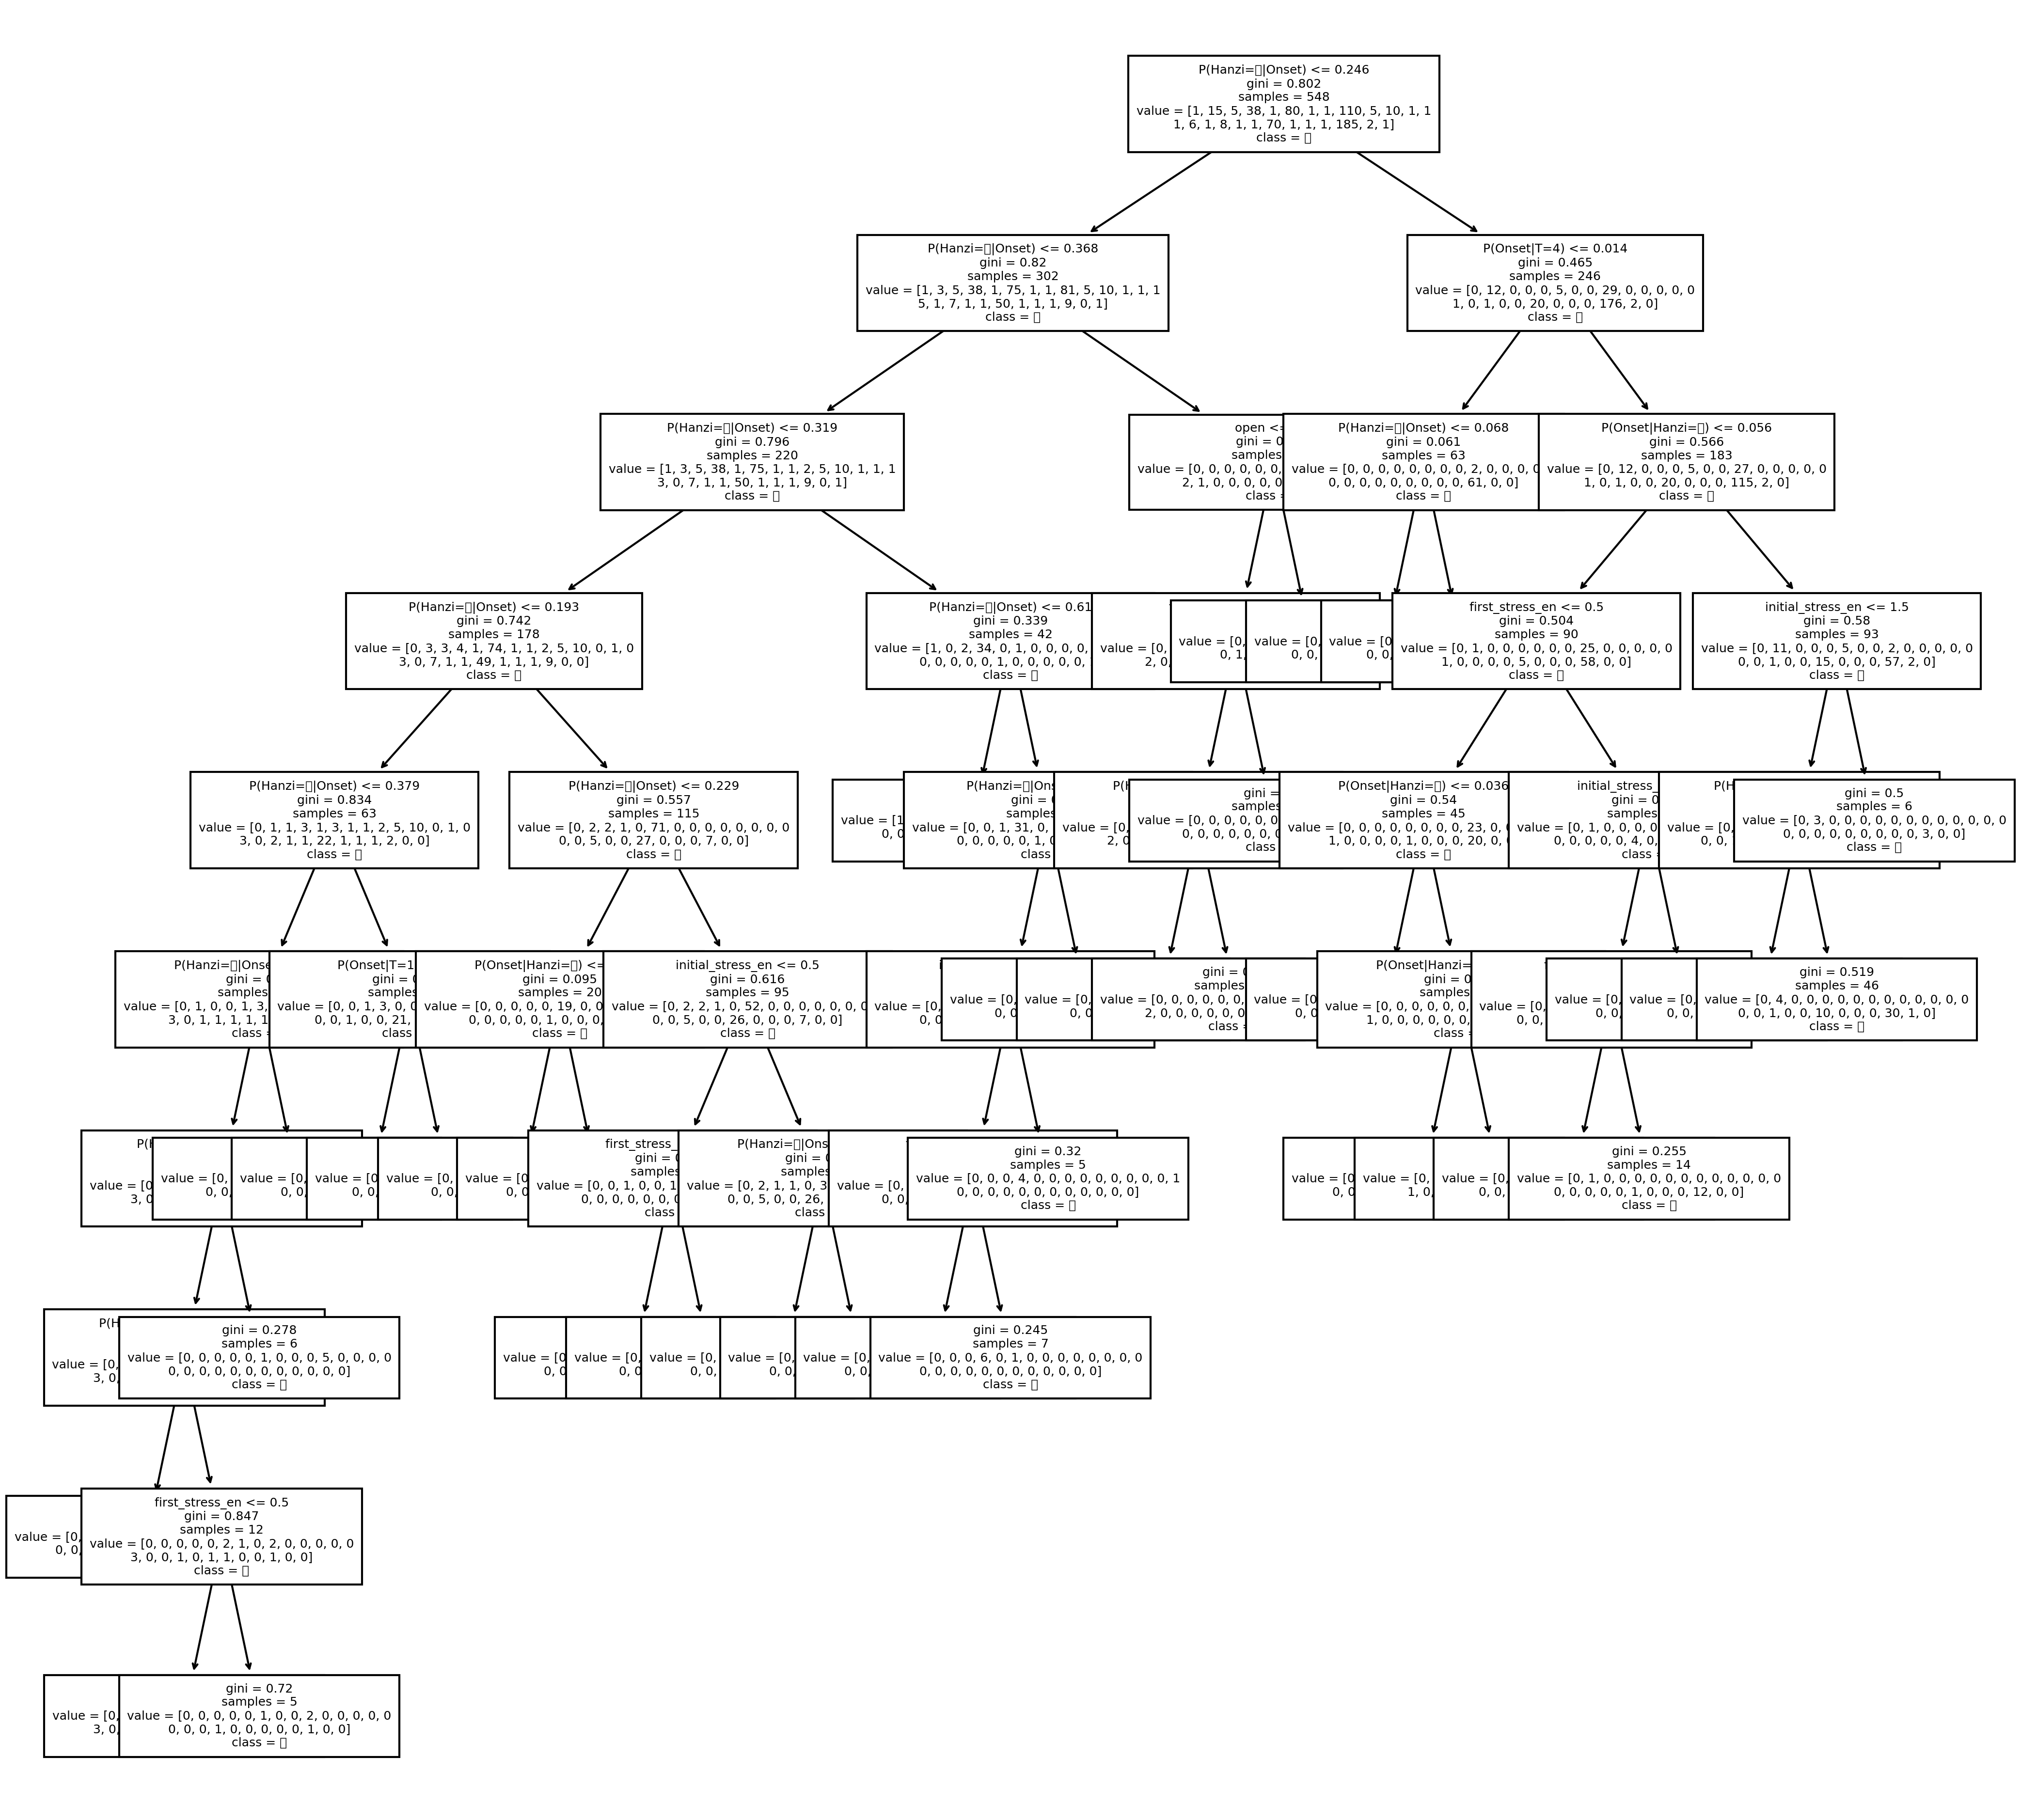

In [107]:
print(f"X_labels: {X_labels}")
print(f"y_labels: {y_labels}")

set_config(print_changed_only=False)
print(clf)

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,16), dpi=300)
tree = plot_tree(clf, feature_names=X_labels, class_names=y_labels, ax=axes, fontsize=6)
plt.savefig("./data/tree.png")

tree_text_raw = export_text(clf, feature_names=X_labels[:len(X[0])]).split("\n")
tree_text_numbered = []

l = 0
for line in tree_text_raw:
    if "class: " in line and "-" in line:
        prefix = "   "
    else:
        l += 1
        prefix = str(l).ljust(3)

    if "|" in line:
        tree_text_numbered.append(prefix + line)

tree_text_numbered = "\n".join(tree_text_numbered)
print(tree_text_numbered)

In [108]:
print_metrics.print_metrics(X_test, y_test, y_pred, X_labels, y_labels, clf=clf, print_probas=False, print_sandhi_effects=False)

([1, False, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 22, 0.028469750889679714, 0, 0, 0.01929260450160772, 0, 0, 0, 0, 0.025974025974025976, 0.017241379310344827, 0.06153846153846154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.18181818181818182, 0.09090909090909091, 0.7272727272727273, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, True], '艾', '阿')
([1, False, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 2, 91, 0.10854092526690391, 0, 0, 0.09646302250803858, 0, 0, 0, 0, 0.14935064935064934, 0.05172413793103448, 0.2230769230769231, 0, 0, 0.043478260869565216, 0, 0.14285714285714285, 0.01818181818181818, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25274725274725274, 0.06593406593406594, 0.6373626373626373, 0, 0, 0.01098901098901099, 0, 0.02197802197802198, 0.01098901098901099, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
